In [1]:
import read
import spatialdata
import spatialentropy
import numpy as  np

In [4]:
coor_matrix = read.read_txt(filename='/Users/zhujun/Documents/毕业设计/SHA/SHAcode/data/cell_locations/cortex_svz_centroids_coord.txt',delimiter='\t', column_names=[0])

In [5]:
ann_matrix= read.read_txt(filename='/Users/zhujun/Documents/毕业设计/SHA/SHAcode/data/cell_locations/cortex_svz_centroids_annot.txt', delimiter='\t', column_names=[0])

In [6]:
expression_matrix = read.read_txt(filename='/Users/zhujun/Documents/毕业设计/SHA/SHAcode/data/count_matrix/cortex_svz_expression.txt', delimiter=' ', column_names=[0])

In [67]:
fov6_coor = coor_matrix[523:804]
fov6_types = ann_matrix[523:804]
fov6_exp = expression_matrix.iloc[ :, 523:804]

In [9]:
cell_types = set(fov6_types)

{'Astrocyte',
 'Choroid Plexus',
 'Endothelial',
 'Ependymal',
 'Excitatory neuron',
 'Interneuron',
 'Microglia',
 'Neural Stem',
 'Neuroblast',
 'Oligodendrocyte'}

In [180]:
fov7_types = ann_matrix[804:913]['cell_types']
set(fov7_types)

{'Choroid Plexus', 'Endothelial', 'Microglia', 'Neural Stem'}

In [ ]:
fov0_types = ann_matrix[:118]['cell_types']
set(fov7_types)

In [83]:
from sklearn.metrics.pairwise import pairwise_distances
import math

In [227]:
def laplacian_score(w_matrix,e_matrix,sort='decending'):
    n_genes = e_matrix.shape[0]
    n_cells = e_matrix.shape[1]
    feature_dict = {}
    for i in range(n_genes):
        name = e_matrix.iloc[i].name
        var_feature = e_matrix.iloc[i].var()
        if var_feature == 0:
            continue
        fr = 0.0
        for cell1 in range(n_cells):
            for cell2 in range(cell1+1, n_cells):
                fr += ((e_matrix.iloc[i][cell1] - e_matrix.iloc[i][cell2])**2) * w_matrix[cell1][cell2]
        lp_score = fr / var_feature
        feature_dict[name] = lp_score
        feature_df = pd.DataFrame.from_dict(feature_dict, orient='index',columns=['lp_score'])
        feature_df.index.name = 'genes'
        if sort == 'decending':
            sorted_df = feature_df.sort_values(by='lp_score',ascending=False)
        else:
            sorted_df = feature_df.sort_values(by='lp_score',ascending=True)       
    return sorted_df

In [228]:
def cell_laplacian_score(celltype,coor,ann,exp,sort='decending'):
    
    indexs = [ann.iloc[i].name for i in range(len(ann)) if ann.iloc[i]['cell_types'] == celltype]
    new_coor = pd.DataFrame(coor,index=indexs)
    new_ann = pd.DataFrame(ann,index=indexs)
    new_exp = pd.DataFrame(exp,columns=indexs)
    n_length = len(new_coor)
    d_matrix = pairwise_distances(new_coor)
    d_max = d_matrix.max()
    d_min = d_matrix.min()
    for i in range(n_length):
        for j in range(n_length):
            if i == j:
                d_matrix[i][j] = 0
            else:
                d_matrix[i][j] = math.exp(-(d_matrix[i][j] - d_min)/(d_max - d_min))
    ls = laplacian_score(d_matrix,new_exp,sort)
    return ls

In [130]:
indexs = [fov6_types.iloc[i].name for i in range(len(fov6_types)) if fov6_types.iloc[i]['cell_types'] == 'Neuroblast']
new_coor = pd.DataFrame(fov6_coor,index=indexs)
new_ann = pd.DataFrame(fov6_types,index=indexs)
new_exp = pd.DataFrame(fov6_exp,columns=indexs)

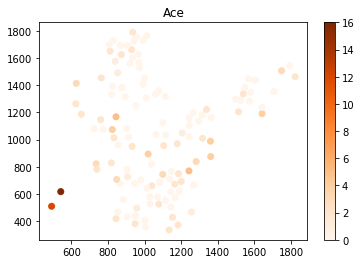

In [224]:
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap('Oranges')
sc = plt.scatter(new_coor['X'], new_coor['Y'], c=new_exp.loc['Kif5a'], cmap=cm)
plt.colorbar(sc)
plt.title("Ace")
plt.show()

## 修改差异基因（特征筛选的算法）

In [162]:
cell_laplacian_score('Neuroblast',fov6_coor,fov6_types,fov6_exp[:50],sort='acending')

,lp_score
genes,
9330102e08rik,11221.746799
Abca8a,11063.187046
Ablim2,11044.414050
1700025g04rik,11039.702732
Abat,10950.420078
Ackr3,10950.074609
4933401b06rik,10937.345563
Acot6,10933.759230
Acsl5,10924.827439


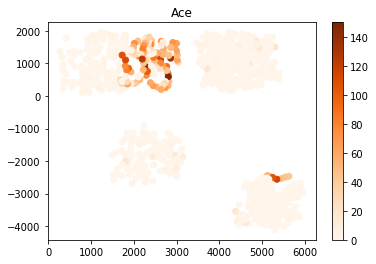

In [194]:
cm = plt.cm.get_cmap('Oranges')
sc = plt.scatter(coor_matrix['X'], coor_matrix['Y'], c=expression_matrix.loc['Enpp2'], cmap=cm)
plt.colorbar(sc)
plt.title("Ace")
plt.show()

## 将全部区域的细胞合并起来

In [ ]:
fov0_coor = coor_matrix[:118]
fov1_coor = coor_matrix[118:226]
fov2_coor = coor_matrix[226:316]
fov3_coor = coor_matrix[316:422]
fov4_coor = coor_matrix[422:523]
fov5_coor = coor_matrix[523:804]
fov6_coor = coor_matrix[804:913]

In [174]:
all_fov = coor_matrix
all_fov.iloc[118:226,0] += 1654.97
all_fov.iloc[226:316,0] += 1750.75
all_fov.iloc[316:422,0] += 1674.35
all_fov.iloc[422:523,0] += 675.5
all_fov.iloc[523:804,0] += 2048
all_fov.iloc[804:913,0] += 675
all_fov.iloc[422:523,1] += -1438.02
all_fov.iloc[523:804,1] += -(1438.02+1438.02)

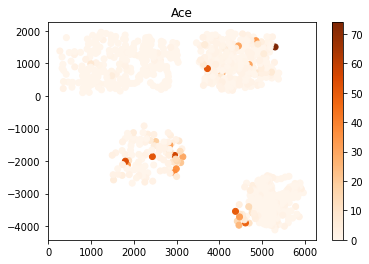

In [213]:
cm = plt.cm.get_cmap('Oranges')
sc = plt.scatter(all_fov['X'], all_fov['Y'], c=expression_matrix.loc['Cnp'], cmap=cm)
plt.colorbar(sc)
plt.title("Ace")
plt.show()

## 根据方差先过滤在少数细胞中表达的基因

In [181]:
fov6_exp

,cell_524,cell_525,cell_526,cell_527,cell_528,cell_529,cell_530,cell_531,cell_532,cell_533,...,cell_795,cell_796,cell_797,cell_798,cell_799,cell_800,cell_801,cell_802,cell_803,cell_804
1700022a21rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1700025g04rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4933401b06rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5830417i10rik,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,1,0
9330102e08rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pde6b,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2,0,1,0,0,0
Zp1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Dlx4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
Opn1sw,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
n_genes = len(fov6_exp)
gene_var = {}
for i in range(n_genes):
    gene_var[fov6_exp.iloc[i].name] = fov6_exp.iloc[i].var()

In [191]:
genes_order = sorted(gene_var.items(),key=lambda x:x[1],reverse=True)

In [204]:
indexs2 = [genes_order[i][0] for i in range(1000)]
df = pd.DataFrame(fov6_exp,index=indexs2)

In [206]:
def filtergenes(n_genes,exp):
    genes_len = len(exp)
    genes_var = {}
    for i in range(genes_len):
        genes_var[exp.iloc[i].name] = exp.iloc[i].var()
    genes_order = sorted(genes_var.items(),key=lambda x:x[1],reverse=True)
    filter_indexs = [genes_order[j][0] for j in range(n_genes)]
    return pd.DataFrame(exp,index=filter_indexs)   

In [231]:
filtered_genes = filtergenes(100,fov6_exp)

In [238]:
cell_laplacian_score('Neuroblast',fov6_coor,fov6_types,filtered_genes,sort='acending')

,lp_score
genes,
Pltp,9515.139525
Cnp,9719.497237
Kif5a,9790.199774
Plekhb1,9849.447567
Bcas1,9858.441150
...,...
Cldn11,10876.988343
Pcolce,10934.956605
Gas6,10950.065832


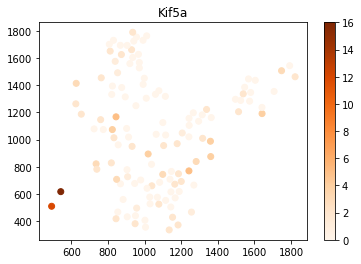

In [252]:
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap('Oranges')
sc = plt.scatter(new_coor['X'], new_coor['Y'], c=new_exp.loc['Kif5a'], cmap=cm)
plt.colorbar(sc)
plt.title("Kif5a")
plt.show()

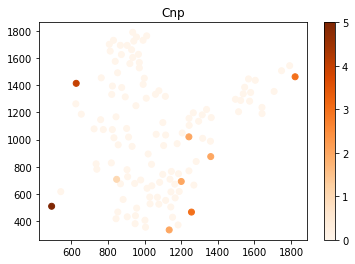

In [253]:
sc = plt.scatter(new_coor['X'], new_coor['Y'], c=new_exp.loc['Cnp'], cmap=cm)
plt.colorbar(sc)
plt.title("Cnp")
plt.show()

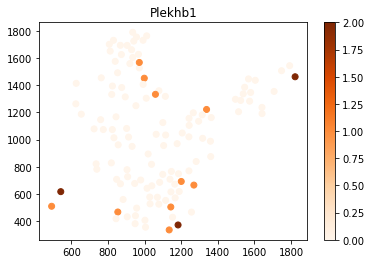

In [254]:
sc = plt.scatter(new_coor['X'], new_coor['Y'], c=new_exp.loc['Plekhb1'], cmap=cm)
plt.colorbar(sc)
plt.title("Plekhb1")
plt.show()

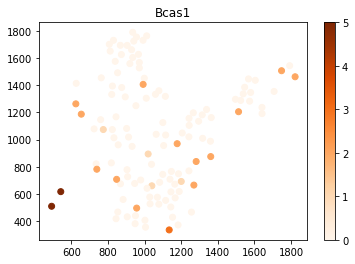

In [255]:
sc = plt.scatter(new_coor['X'], new_coor['Y'], c=new_exp.loc['Bcas1'], cmap=cm)
plt.colorbar(sc)
plt.title("Bcas1")
plt.show()

,FOV,cell_types
ID,,
cell_524,5,Neural Stem
cell_525,5,Neural Stem
cell_526,5,Neuroblast
cell_527,5,Neuroblast
cell_528,5,Neuroblast
...,...,...
cell_800,5,Neural Stem
cell_801,5,Neural Stem
cell_802,5,Oligodendrocyte
